## N차 과제 - Time Series Analysis_주가예측

- 주제: 시계열 모델을 주가 데이터에 대한 시계열 예측 및 분석
- 데이터: 주식 데이터(크롤링 or 라이브러리로 데이터 불러오기)
- 사용 라이브러리: yfinance, datareader, statsmodels, matplotlib etc.

In [4]:
pip install yfinance

     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     ---------------------------------------  2.9/3.0 MB 16.8 MB/s eta 0:00:01
     ---------------------------------------- 3.0/3.0 MB 15.7 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for peewee: filename=peewee-3.17.6-py3-none-any.whl size=138939 sha256=2b87cf3dce9537ffc1091c135a25348acefa6f656cbd6535ac65c2f3afd3cfe0
  Stored in directory: c:\users\lenovo\appdata\local\pip\cache\wheels\a6\5e\0f\8319805c4115320e0d3e8fb5799b114a2e4c4a3d6c7e523b06
Successfully built peewee
Note: you may need to restart the kernel to use updated packages.


In [8]:
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

### 1. EDA 및 전처리

1.1 분석을 위해 사용할 특정 주식(1개)의 데이터를 불러오거나 크롤링하여 가져오세요(**최소 3년 이상의 데이터 추출 권고**).

In [12]:
###엔비디아 ticker는 NVDA임
ticker = 'NVDA'

# 오늘 날짜
end_date = datetime.datetime.now()

# 3년 전 날짜 계산(현재 날짜에서 -했으니까 3년 전. 즉 21년 10월 8일부터 나오게됨)
start_date = end_date - datetime.timedelta(days=3*365)

# yfinance를 사용하여 데이터 다운로드
nvidia_data = yf.download(ticker, start=start_date, end=end_date)

print(nvidia_data.head())

[*********************100%***********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2021-10-08  21.101000  21.205999  20.775000  20.830999  20.795298  151258000
2021-10-11  20.575001  21.063000  20.511000  20.695000  20.659534  163388000
2021-10-12  20.827999  21.056999  20.528000  20.671000  20.635576  162134000
2021-10-13  20.917999  20.990000  20.712999  20.938999  20.903112  180652000
2021-10-14  21.288000  21.754999  21.122000  21.746000  21.708733  243589000


1.2 결측치가 있는지 확인하고 있다면 제거해주세요.

In [16]:
print("결측치 개수 확인\n", nvidia_data.isnull().sum())

결측치 개수 확인
 Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
###결측치 없요요

1.3 일자를 인덱스로 설정하고 시간 순서대로 정렬하세요.

In [18]:
# 일자(Date)를 인덱스로 설정
nvidia_data.index = pd.to_datetime(nvidia_data.index)

# 시간 순서대로 정렬 (ascending =True로 설정해서 오름차순:시간순서대로 정렬했음)
nvidia_data = nvidia_data.sort_index(ascending=True)

print(nvidia_data.head())

                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2021-10-08  21.101000  21.205999  20.775000  20.830999  20.795298  151258000
2021-10-11  20.575001  21.063000  20.511000  20.695000  20.659534  163388000
2021-10-12  20.827999  21.056999  20.528000  20.671000  20.635576  162134000
2021-10-13  20.917999  20.990000  20.712999  20.938999  20.903112  180652000
2021-10-14  21.288000  21.754999  21.122000  21.746000  21.708733  243589000


1.4 수정종가(adj close)와 거래량(volume)을 시각화하세요.

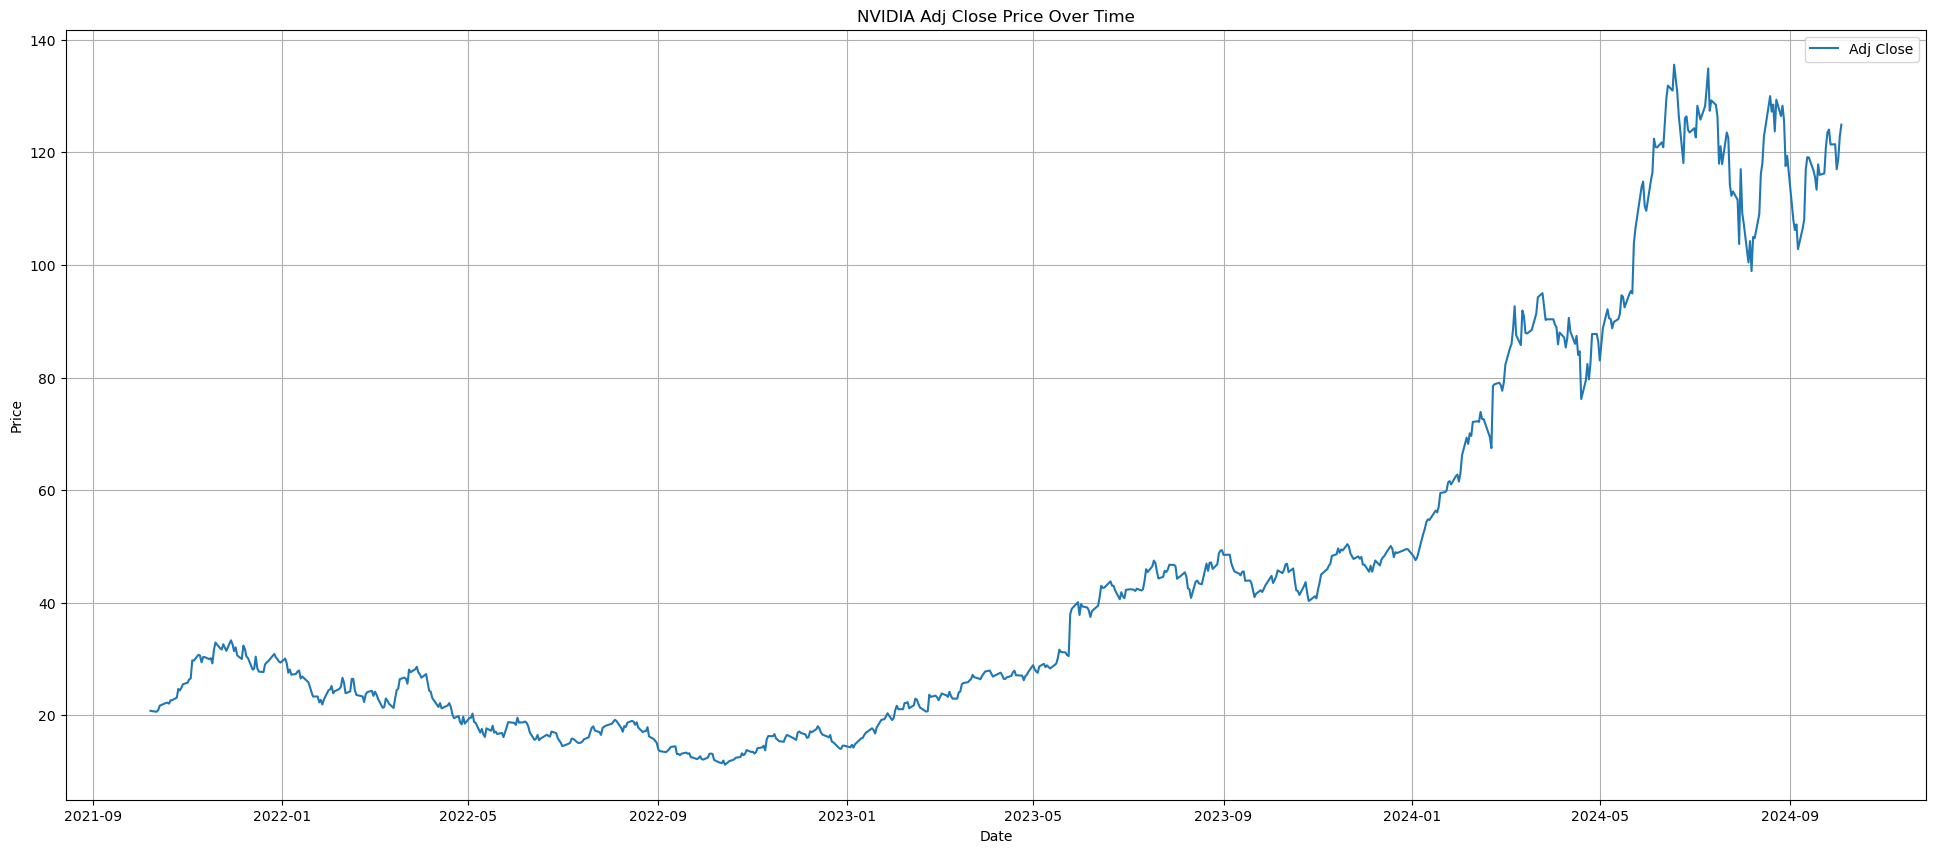

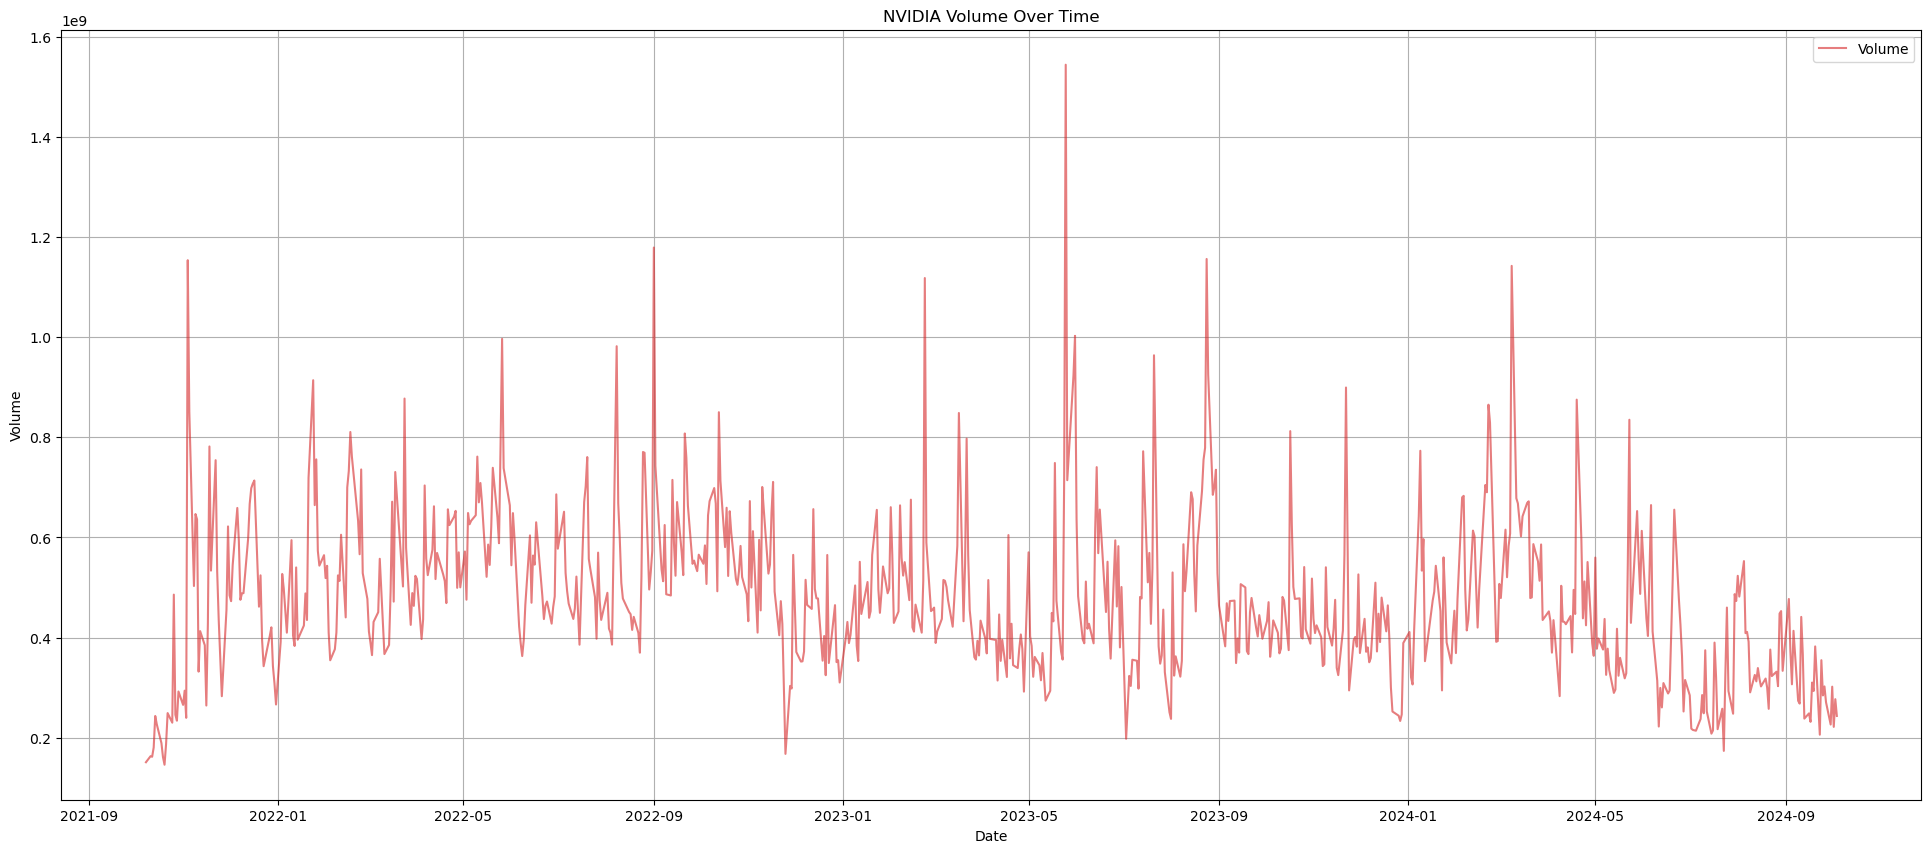

In [36]:
#### NVIDIA Adj Close price over time 그래프
plt.figure(figsize=(24,10))
plt.plot(nvidia_data.index, nvidia_data['Adj Close'], color = 'tab:blue', label= 'Adj Close')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('NVIDIA Adj Close Price Over Time')
plt.legend()
plt.grid(True)
plt.show()
### NVIDIA Volume over time 그래프
plt.figure(figsize=(24,10))
plt.plot(nvidia_data.index, nvidia_data['Volume'], color='tab:red', label='Volume', alpha=0.6)
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('NVIDIA Volume Over Time')
plt.legend()
plt.grid(True)
plt.show()

1.5 위 시각화 과정을 통해 알 수 있는 내용에 대해 작성하세요.

In [ ]:
###24년도 3/4분기만 봤을때, 거래량이 계속 감소하는데 주가는 호버링하고 있는데 기관이 관망하고 있다고 볼수있고 130$ 정도에서 강력한 저항선을 형성한 것을 알 수 있다.

### 2. 추세 및 정상성 검정

2.1 시계열 데이터의 정상성을 검증하도록 하겠습니다. 시계열 데이터 말하는 정상성(stationarity)이 무엇인지 왜 해야 하며 비정상성의 해결 방법에는 무엇이 있는지 작성하세요.

###########오늘 처음보는거라 좀 어려웠습니다. 양해 부탁드립니다.###########
시계열 데이터의 stationarity는 ARIMA같은 모델을 적용하기 위한 기본 가정으로서 검증이 필요하다.
Stationarity란 시계열 데이터의 통계적 특성이 시간에 따라 변하지 않는 상태이다. 여기서 통계적 특성은 평균, 분산, 자기공분산을 의미한다.
Stationarity를 해결하기 위한 방법
1. 차분(Differencing): ARIMA 모델링에서 시계열 데이터를 정상성으로 만들기 위해 1,2차 차분을 사용한다고 함
2. 로그 변환(Log Transformation): 주가와 같은 큰 변동성을 가진 데이터에 매우 효과적이다. 데이터의 분산을 안정화하는데 유용한 방법이다. log transformation 후 differencing 해도 된다.
3. 시계열 분해(Time Series Decomposition): 타임 시리즈 데이터를 추세, 계절성, 잔차로 분해하여 정상성을 확보하는 방법인데, 계절성과 추세가 뚜렷한 데이터에 많이 사용된다.

2.2 먼저 ADF Test를 수행하겠습니다. statsmodels의 adfuller 라이브러리를 import 한 후 수정 종가에 대한 검정을 수행하고 결과를 출력하세요(p-value 포함).

ADF Test란? - https://hongl.tistory.com/98

In [38]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(nvidia_data['Adj Close'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 1.031324
p-value: 0.994586
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


2.3 ADF Test 결과를 해석하세요.

p-value가 매우 높고, ADF 통계량이 1.031인데 1%, 5%, 10%수준 임계 값이 각각 -3.439, -2.865, -2.569이므로 ADF 통계량이 모든 임계값보다 더 크다. 그러므로 귀무가설인 '데이터가 비정상적이다'를 기각할 수 없고, 이는 데이터가 비정상성을 가지고 있다는 것을 알 수 있다.

2.4 ACF 그래프와 PACF 그래프를 그려보도록 하겠습니다. 먼저 ACF와 PACF 각각이 어떻게 다른지 설명하세요.

ACF: 시계열 데이터에서 자기상관(autocorrelation)을 측정하는 함수. 모든 이전 시점들의 상관관계가 포함된 누적된 상관관계를 보여준다. MA모델의 차수를 선택하는데 사용
PACF: 특정 시차(lag)에서의 부분 자기상관(partial autocorrelation)을 측정하는 함수. 특정시차에서 순수한 시차 상관을 알수 있다. AR모델의 차수를 선택하는데 사용

2.5 statsmodels의 plot_acf, plot_pacf 라이브러리를 import하고 Adj close값에 대한 ACF, PACF 그래프를 출력하세요.

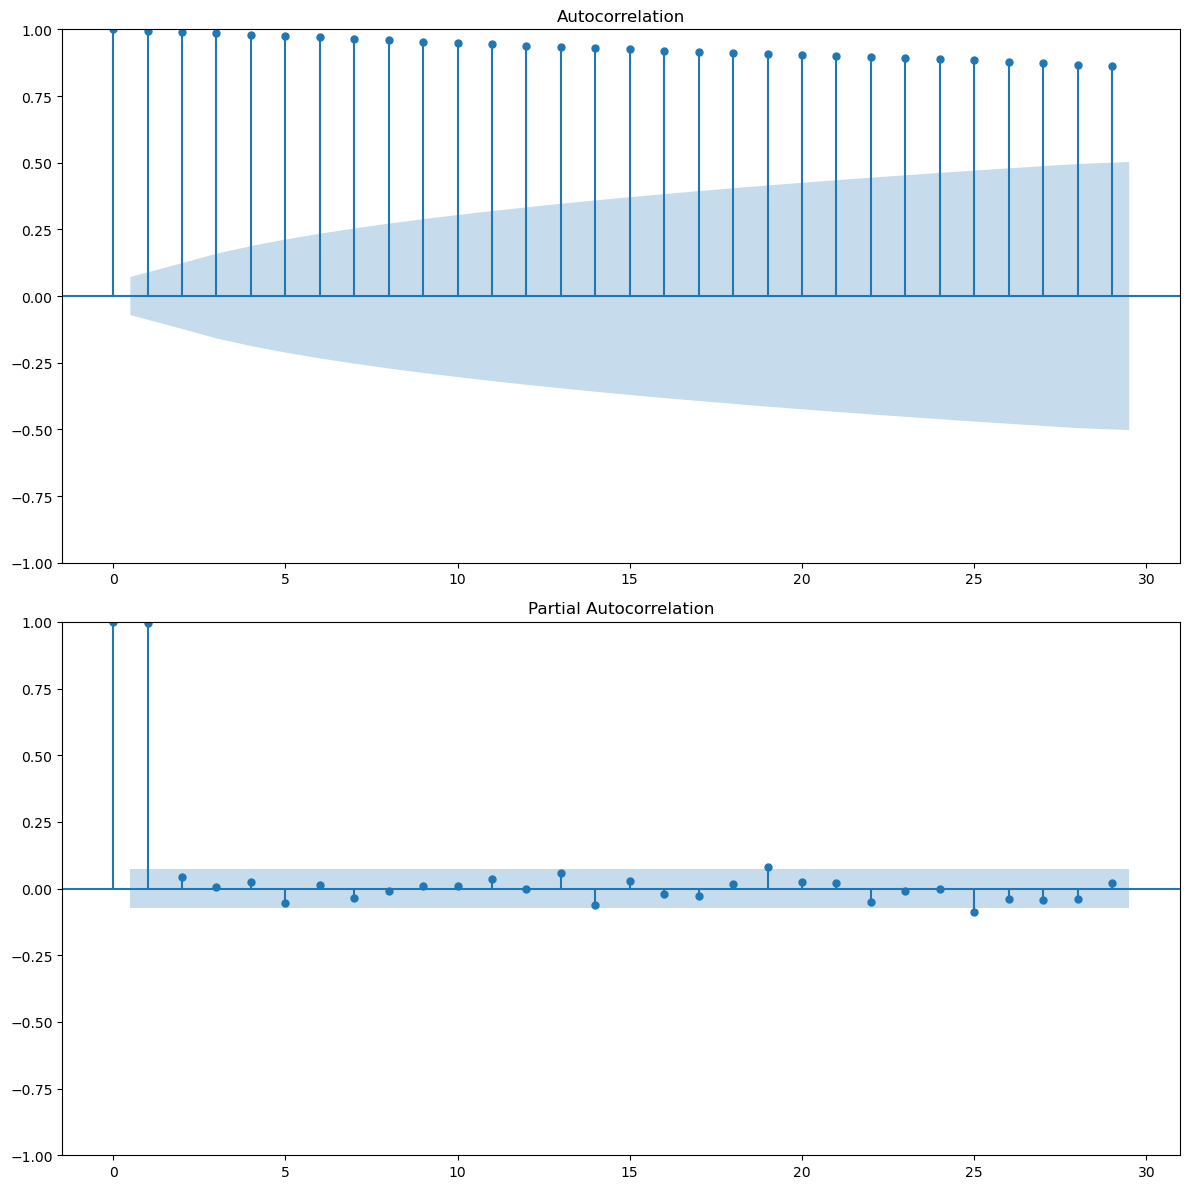

In [49]:
plt.figure(figsize=(12,12))
#ACF
plt.subplot(211)
plot_acf(nvidia_data['Adj Close'].dropna(), ax=plt.gca())
plt.title('Autocorrelation')

# PACF
plt.subplot(212)
plot_pacf(nvidia_data['Adj Close'].dropna(), ax=plt.gca())
plt.title('Partial Autocorrelation')

plt.tight_layout()
plt.show()

2.6 결과를 해석하세요.

ACF그래프에서는 ACF 값이 lag 1부터 계속 매우 높은 값을 보이며 느리게 감소하는데, 정상성 시계열 데이터는 빠르게 0으로 수렴해야 하지만 안그러므로 비정상성 데이터일 가능성이 높다. 즉 현재 데이터에 추세가 포함되어 있어 시간이 지남에 따라 자기상관이 유지된다.
PACF 그래프에서는 lag 1에서 매우 값이 크고 다른 값들은 거의 0에 가까운데 이는 AR(1)모델이 적합하다는 걸 보여준다.

2.7 마지막으로 계절성이 있는지 여부를 확인하겠습니다. statsmodels의 seasonal_decompose 라이브러리를 import하고 plot을 출력하세요.

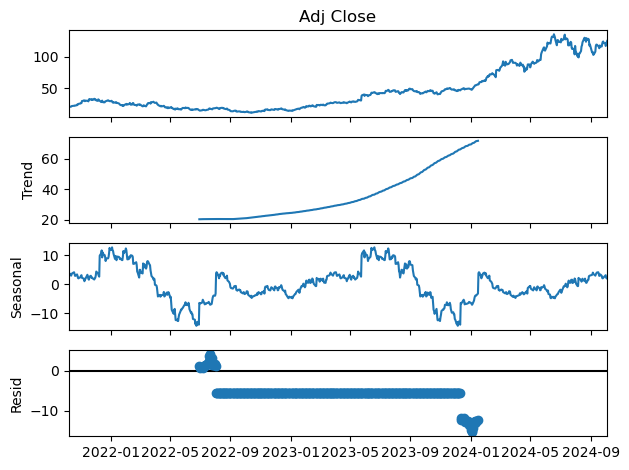

In [51]:
decomposition = seasonal_decompose(nvidia_data['Adj Close'].dropna(), model='additive', period=365)

# 분해된 시계열 데이터 시각화
decomposition.plot()
plt.tight_layout()
plt.show()

2.8 위 결과를 해석하세요.

일단 추세가 존재한다. 23년도부터 급격하게 상승하므로 비정상성 시계열이라고 볼 수 있고,
계절성이 크지는 않지만 약간의 반복적 움직임이 보이긴한다.
그리고 잔차가 22년도 7월, 24년도 1월에 모종의 시장 충격으로 불규칙적으로 분포되어있음을 알수있다.
즉, 전형적인 비정상성 시계열데이터이다.

2.9 위에서 진행한 검정 과정 및 시각화 결과를 종합해봤을 때 현 데이터는 비정상성임을 알 수 있습니다. 따라서 차분을 통해 이를 해결하도록 하겠습니다. 먼저 차분이 어떤 것인지에 대해 설명하세요.

추세가 존재하는 비정상성 시계열데이터 처리하는 방법중 하나. 현재 시점 데이터값에서 이전 시점 데이터 값을 빼면 된다.

2.10 1차 차분을 진행하도록 하겠습니다. diff() 함수를 활용해 1차 차분을 진행한 후 ADF Test를 수행하여 정상성 여부를 확인하세요.

In [55]:
nvidia_data['Adj Close Diff'] = nvidia_data['Adj Close'].diff()
# ADF test
adf_result_diff = adfuller(nvidia_data['Adj Close Diff'].dropna())
print('ADF Statistic (Differenced): %f' %adf_result_diff[0])
print('p-value (Differenced): %f' %adf_result_diff[1])
print('Critical Values (Differenced):')
for key, value in adf_result_diff[4].items():
    print('\t%s: %.3f' %(key, value))

### p value가 0.05 미만이니까 정상성 확보했요요

ADF Statistic (Differenced): -7.047965
p-value (Differenced): 0.000000
Critical Values (Differenced):
	1%: -3.439
	5%: -2.865
	10%: -2.569


2.11 추가로 위에서 그려보았던 plot들을 다시 그려보면서 비교를 통해 정상성 여부를 확인해보도록 하겠습니다. ACF PACF plot, 계절성 분해 plot을 그려보세요.

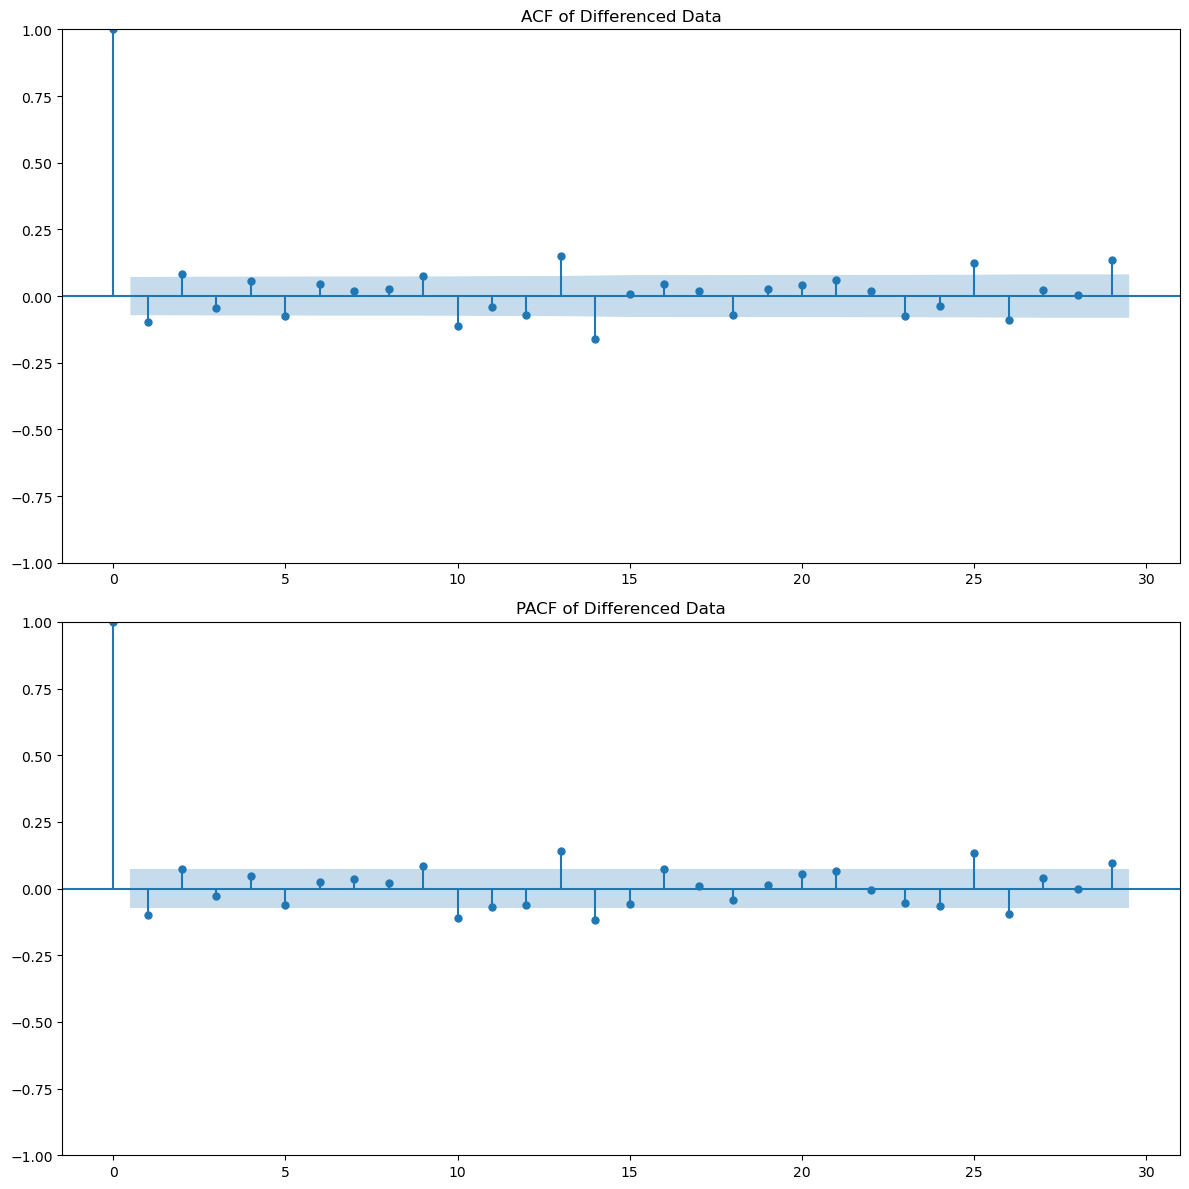

In [59]:
plt.figure(figsize=(12, 12))

plt.subplot(211)
plot_acf(nvidia_data['Adj Close Diff'].dropna(), ax=plt.gca())
plt.title('ACF of Differenced Data')

plt.subplot(212)
plot_pacf(nvidia_data['Adj Close Diff'].dropna(), ax=plt.gca())
plt.title('PACF of Differenced Data')

plt.tight_layout()
plt.show()

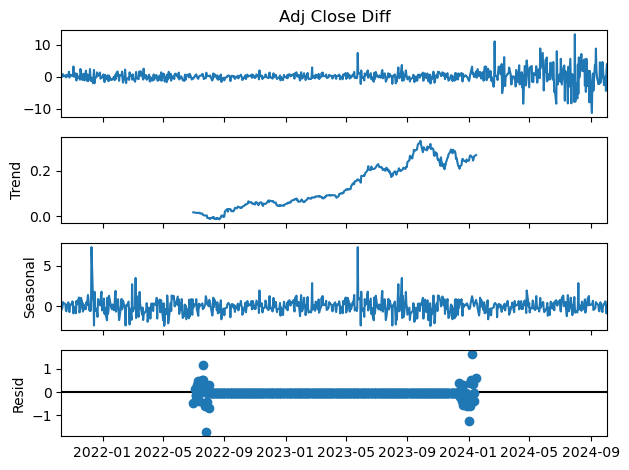

In [61]:
decomposition_diff = seasonal_decompose(nvidia_data['Adj Close Diff'].dropna(), model='additive', period=365)
decomposition_diff.plot()
plt.tight_layout()
plt.show()

### 3. 예측

3.1 데이터의 정상성을 확인했으니 본격적으로 예측 및 분석을 진행해보도록 하겠습니다.

아래 코드는 예시이므로 예시에서 사용된 모델이 아닌 다른 모델(ex. ARIMAX, ARCH/GARCH, LSTM, Transformer, DLinear etc.)를 사용하고 애플이 아닌 다른 주식을 사용해 예측 및 분석을 진행해주세요(**위에서 진행한 과정 역시 모두 예시이므로 새로운 주식에 대한 전처리 및 정상성 검정을 새로 진행해야 함**).

In [12]:
from statsmodels.tsa.arima.model import ARIMA

In [23]:
data['Adj Close_diff']

Date
2019-01-02         NaN
2019-01-03   -3.760181
2019-01-04    1.450996
2019-01-07   -0.078880
2019-01-08    0.674103
                ...   
2023-12-22   -1.075882
2023-12-26   -0.547943
2023-12-27    0.099625
2023-12-28    0.428375
2023-12-29   -1.046036
Name: Adj Close_diff, Length: 1258, dtype: float64

In [24]:
model = ARIMA(data['Adj Close_diff'], order=(3, 0, 0))  #위에서 차분을 미리 했으므로 차분 값은 0으로 설정
model_fit = model.fit()


model_fit.summary()

C:\Users\bumbk\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\bumbk\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\bumbk\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         Adj Close_diff   No. Observations:                 1258
Model:                 ARIMA(3, 0, 0)   Log Likelihood               -2858.574
Date:                Tue, 27 Aug 2024   AIC                           5727.148
Time:                        23:58:51   BIC                           5752.834
Sample:                             0   HQIC                          5736.801
                               - 1258                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1227      0.062      1.969      0.049       0.001       0.245
ar.L1         -0.0434      0.022     -1.986      0.047      -0.086      -0.001
ar.L2         -0.0264      0.023     -1.162      0.245      -0.071       0.018
ar.L3         -0.0158      0.024     -0.658      0.511      -0.063       0.031
sigma2         5.5310      0.149     37.232      0.000       5.240       5.822
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               349.98
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.12   Skew:                            -0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\bumbk\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


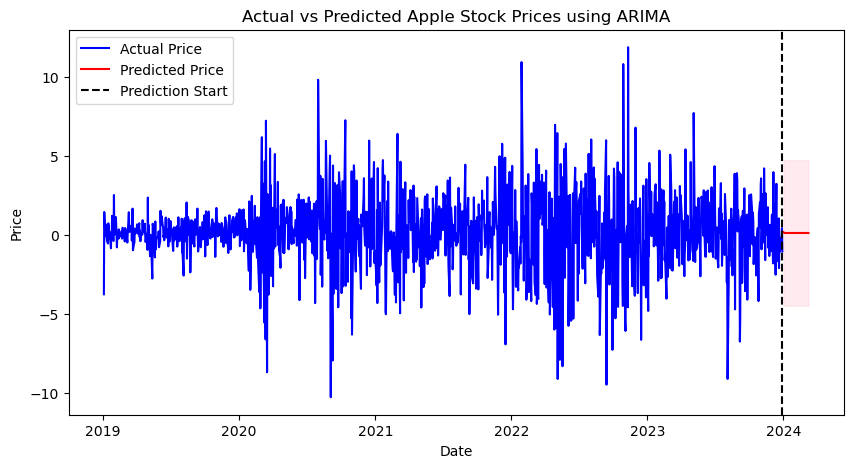

In [26]:
#예측 수행(50일, 200일해도 달라지지 않았음 ㅠ)
forecast_result = model_fit.get_forecast(steps=50)
forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

#예측 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot(df.index, data['Adj Close_diff'], label='Actual Price', color='blue')
plt.plot(pd.date_range(start=data.index[-1], periods=51, freq='B')[1:], forecast, label='Predicted Price', color='red')
plt.fill_between(pd.date_range(start=data.index[-1], periods=51, freq='B')[1:], conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.axvline(x=data.index[-1], color='black', linestyle='--', label='Prediction Start')
plt.title('Actual vs Predicted Apple Stock Prices using ARIMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [28]:
#실제 데이터 가져오기
actual_data_last_50 = yf.download(ticker, start='2024-01-01', end='2024-03-01')
actual_last_50 = actual_data_last_50[['Close']]


[*********************100%%**********************]  1 of 1 completed


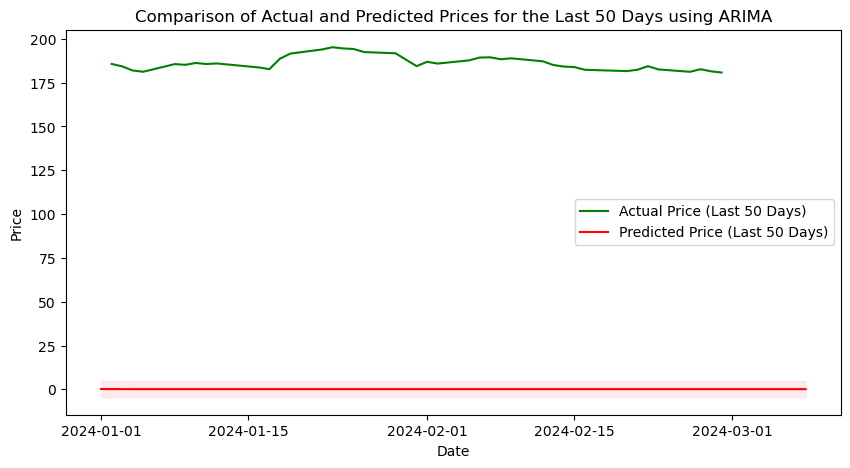

In [29]:
#실제 데이터와 비교 시각화
plt.figure(figsize=(10, 5))
plt.plot(actual_last_50.index, actual_last_50['Close'], label='Actual Price (Last 50 Days)', color='green')
plt.plot(pd.date_range(start=data.index[-1], periods=51, freq='B')[1:], forecast, label='Predicted Price (Last 50 Days)', color='red')
plt.fill_between(pd.date_range(start=df.index[-1], periods=51, freq='B')[1:], conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Comparison of Actual and Predicted Prices for the Last 50 Days using ARIMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

ARIMA에서는 성능이 왠지는 모르겠으나 잘 안 나와서 이정도만 하고 넘어가겠습니다. 밑에서 진행할 Prophet 모형의 경우 예측이 제대로 진행되어 추세를 예측하고자 단기적 예측이라 할 수 있는 50일이 아닌 향후 200일을 예측하였습니다.

### Prophet

Prophet 모델이란?
https://wikidocs.net/233162

In [30]:
from prophet import Prophet

In [31]:
###Prophet의 경우 ARIMA와 검정 및 전처리 과정이 약간 달라 새로 진행하였으며 보다 정확한 추세 예측을 위해 200일까지 예측하였습니다.###


ticker = 'AAPL'
data = yf.download(ticker, start='2019-01-01', end='2024-01-01')

df = data.reset_index()[['Date', 'Close']]
df.columns = ['ds', 'y']  #Prophet에서는 날짜 컬럼을 'ds', 값 컬럼을 'y'로 설정해야 함

[*********************100%%**********************]  1 of 1 completed


In [33]:
#모델 설정(파라미터는 따로 설정하지 않고 진행했으나 보다 정확한 예측을 위해 수정하는 것도 좋음)
model = Prophet()
model.fit(df)

00:06:19 - cmdstanpy - INFO - Chain [1] start processing
00:06:19 - cmdstanpy - INFO - Chain [1] done processing


In [34]:
#200일간의 예측 진행
future = model.make_future_dataframe(periods=200)
forecast = model.predict(future)

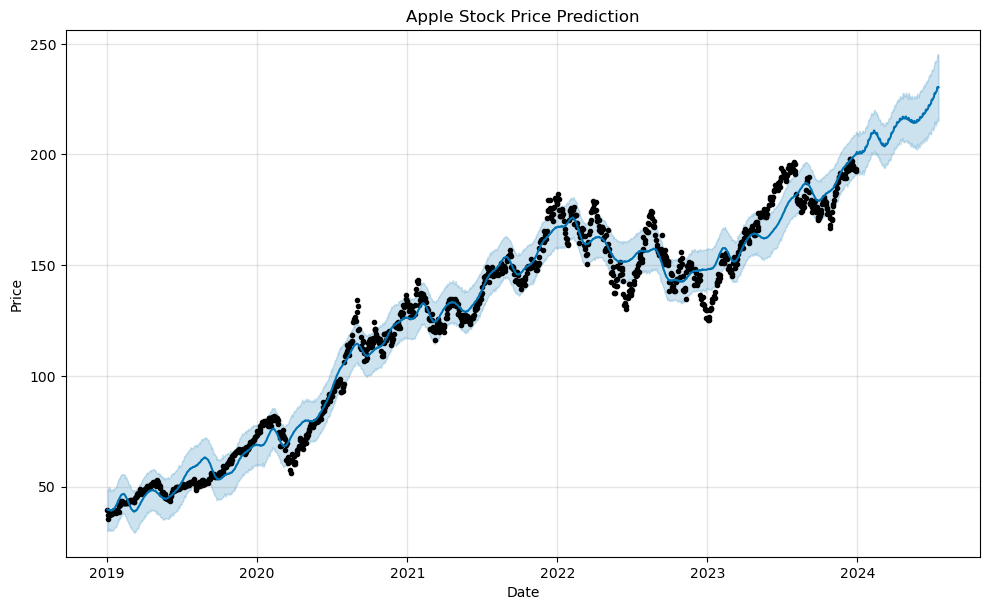

In [35]:
# 예측 결과 시각화
fig1 = model.plot(forecast)
plt.title('Apple Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

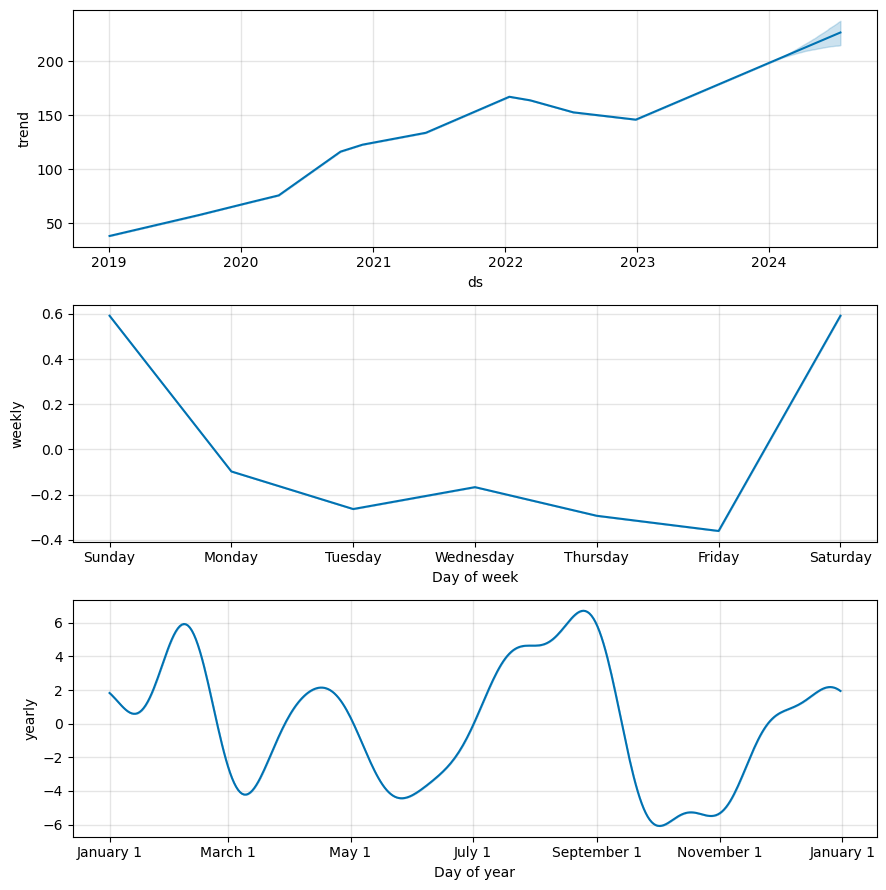

In [36]:
#트렌드 및 주기성 시각화
fig2 = model.plot_components(forecast)
plt.show()

In [37]:
#마지막 200일의 실제 주가 데이터 가져오기
actual_data_last_50 = yf.download(ticker, start='2024-01-01', end='2024-08-01')
actual_last_50 = actual_data_last_50.reset_index()[['Date', 'Close']]
actual_last_50.columns = ['ds', 'y']

[*********************100%%**********************]  1 of 1 completed


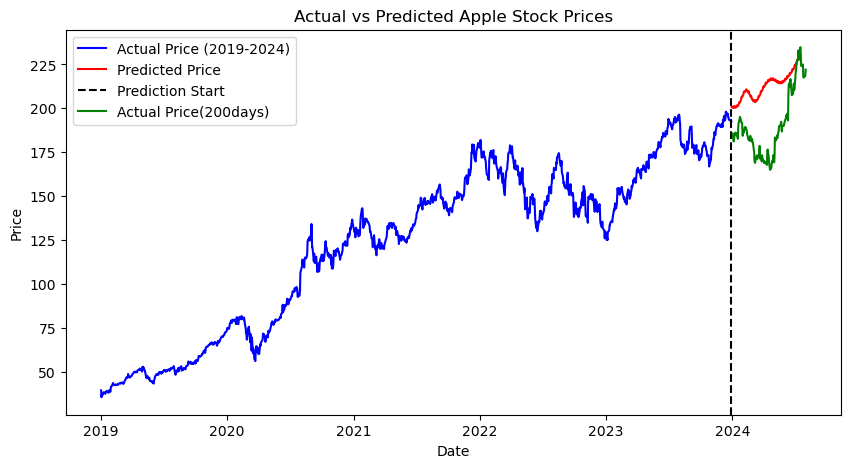

In [41]:
#실제 값과 비교 시각화
plt.figure(figsize=(10, 5))
plt.plot(df['ds'], df['y'], label='Actual Price (2019-2024)', color='blue')

plt.plot(forecast['ds'][len(df):], forecast['yhat'][len(df):], label='Predicted Price', color='red') ##전체 예측값 중 200일 이후 것만 사용
plt.axvline(x=df['ds'].iloc[-1], color='black', linestyle='--', label='Prediction Start')
plt.plot(actual_last_50['ds'], actual_last_50['y'], label='Actual Price(200days)', color='green')
plt.title('Actual vs Predicted Apple Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


예시에서는 전통적 시계열 모형인 ARIMA 보다 최신 기법인 Prophet이 보다 좋은 성능을 보였습니다. 

사실 ARIMA로도 좋은 예측을 진행할 수는 있으나 조금 간단하게 진행하였으며(죄송합니다..시간관계상 ㅠ) SARIMA, ARIMAX와 같이 발전된 모형을 사용하는 것도 방법입니다. 

예시보다 좋은 예측을 진행하여 주시길 바라며 단순히 시각화하는 것을 넘어서 ***RMSE***나 ***MAE***와 같은 성능지표를 활용해 정량적 평가를 진행해주시면 좋을 것 같습니다.

In [ ]:
진짜 너ㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓㅓ무너무 어려웠어요

In [63]:
###위에서 NVIDIA 정상성 검정까지 했으니 그 과정은 여기서 생략함, 그리고 prophet쓸거라 차분안했음

In [93]:
from prophet import Prophet
ticker = 'NVDA'
nvidia_data = yf.download(ticker, start='2019-01-01', end='2024-01-01')
df = nvidia_data.reset_index()[['Date', 'Adj Close']]
df.columns = ['ds', 'y'] #prophet 특징: 날짜:ds 값:y
df = df.sort_values(by='ds') ##혹시 몰라서 날짜 오름차순배열했음
print(df.head())

[*********************100%***********************]  1 of 1 completed

          ds         y
0 2019-01-02  3.378323
1 2019-01-03  3.174215
2 2019-01-04  3.377578
3 2019-01-07  3.556391
4 2019-01-08  3.467852


In [95]:
#모델 설정(파라미터는 따로 설정하지 않고 진행했으나 보다 정확한 예측을 위해 수정하는 것도 좋음)
model = Prophet()
model.fit(df) ##모델에 데이터 피팅

14:39:16 - cmdstanpy - INFO - Chain [1] start processing
14:39:16 - cmdstanpy - INFO - Chain [1] done processing


In [103]:
#280일간의 예측 진행
future = model.make_future_dataframe(periods=280)
forecast = model.predict(future)

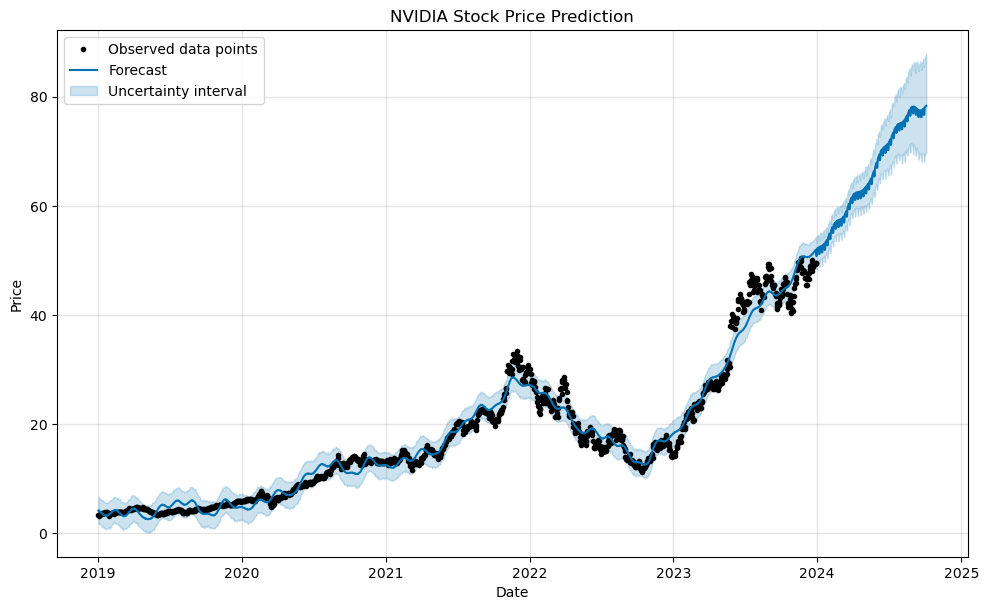

In [105]:
# 예측 결과 시각화
fig1 = model.plot(forecast)
plt.title('NVIDIA Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

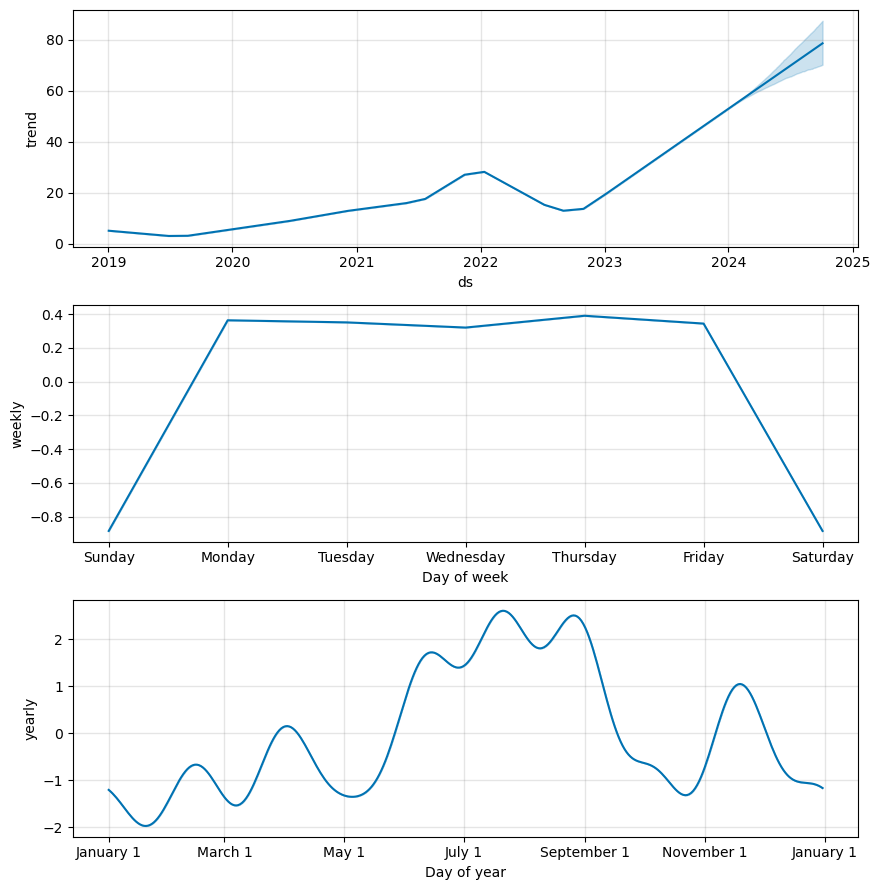

In [107]:
#트렌드 및 주기성 시각화
fig2 = model.plot_components(forecast)
plt.show()

In [129]:
# 실제 데이터 개수 확인
print(f"Actual data length: {len(actual_last_280)}")

Actual data length: 192


In [131]:
#마지막 192일의 실제 주가 데이터 가져오기
actual_data_last_192 = yf.download(ticker, start='2024-01-01', end='2024-10-07')
actual_last_192 = actual_data_last_280.reset_index()[['Date', 'Adj Close']]
actual_last_192.columns = ['ds', 'y']

[*********************100%***********************]  1 of 1 completed


In [133]:
# Prophet 예측값 중 마지막 192일을 실제값과 비교
predicted_last_192 = forecast[['ds', 'yhat']].iloc[-192:]

In [137]:
# RMSE 및 MAE 계산 (Prophet)
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
rmse_prophet = np.sqrt(mean_squared_error(actual_last_192['y'], predicted_last_192['yhat']))
mae_prophet = mean_absolute_error(actual_last_192['y'], predicted_last_192['yhat'])
print(f"Prophet RMSE: {rmse_prophet}")
print(f"Prophet MAE: {mae_prophet}")

Prophet RMSE: 33.03113709229717
Prophet MAE: 28.738782632689276


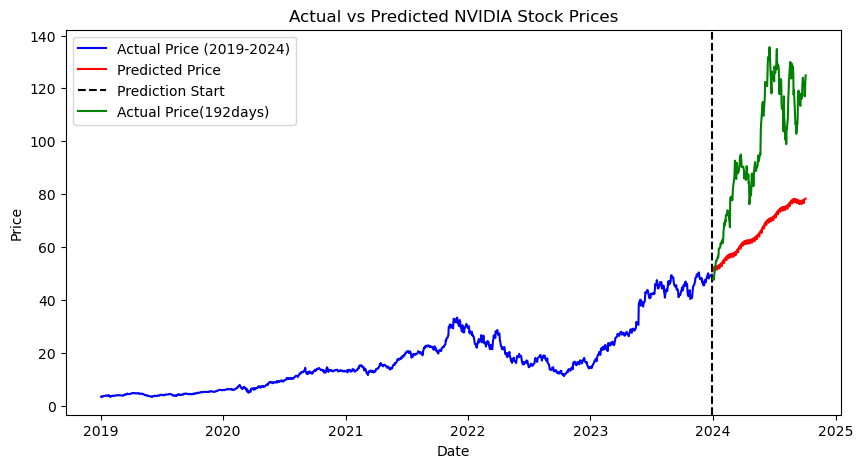

In [139]:
#실제 값과 비교 시각화(prophet)
plt.figure(figsize=(10, 5))
plt.plot(df['ds'], df['y'], label='Actual Price (2019-2024)', color='blue')

plt.plot(forecast['ds'][len(df):], forecast['yhat'][len(df):], label='Predicted Price', color='red') ##전체 예측값 중 192영업일 이후 것만 사용
plt.axvline(x=df['ds'].iloc[-1], color='black', linestyle='--', label='Prediction Start')
plt.plot(actual_last_192['ds'], actual_last_192['y'], label='Actual Price(192days)', color='green')
plt.title('Actual vs Predicted NVIDIA Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [145]:
import statsmodels.api as sm
# SARIMA 모델도 적용해보겠다.
sarima_model = sm.tsa.SARIMAX(df['y'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit()
# SARIMA 192 영업일 예측 (2024년 1월 1일부터 2024년 10월 7일까지)
sarima_forecast = sarima_result.get_forecast(steps=192)
sarima_forecast_df = sarima_forecast.predicted_mean.reset_index()
sarima_forecast_df.columns = ['ds', 'yhat']
# SARIMA 성능 평가
rmse_sarima = np.sqrt(mean_squared_error(actual_last_192['y'], sarima_forecast_df['yhat']))
mae_sarima = mean_absolute_error(actual_last_192['y'], sarima_forecast_df['yhat'])

print(f"SARIMA RMSE: {rmse_sarima}")
print(f"SARIMA MAE: {mae_sarima}")

SARIMA RMSE: 49.932260968292915
SARIMA MAE: 45.092980717477396


In [ ]:
### Prophet이 더 나은 성능을 보인다.

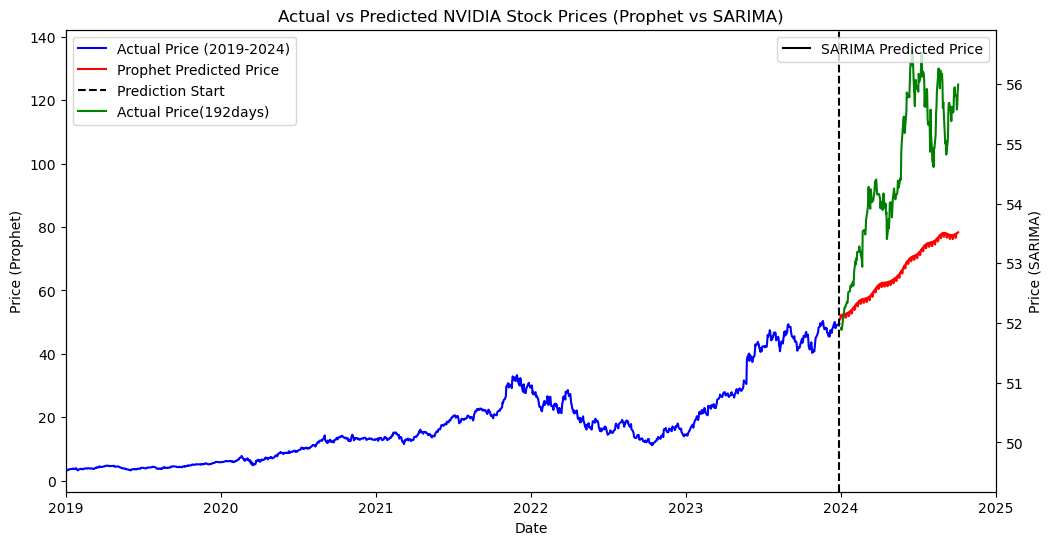

In [169]:
import datetime
import matplotlib.pyplot as plt

# Prophet vs SARIMA 예측 시각화
fig, ax1 = plt.subplots(figsize=(12,6))

# 첫 번째 y축 (Actual and Prophet)
ax1.plot(df['ds'], df['y'], label='Actual Price (2019-2024)', color='blue')
ax1.plot(forecast['ds'][len(df):], forecast['yhat'][len(df):], label='Prophet Predicted Price', color='red')
ax1.axvline(x=df['ds'].iloc[-1], color='black', linestyle='--', label='Prediction Start')
ax1.plot(actual_last_192['ds'], actual_last_192['y'], label='Actual Price(192days)', color='green')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price (Prophet)')
ax1.set_xlim([datetime.datetime(2019, 1, 1), datetime.datetime(2025, 1, 1)])
ax1.legend(loc='upper left')

# 두 번째 y축 (SARIMA)
ax2 = ax1.twinx()
ax2.plot(sarima_forecast_df['ds'], sarima_forecast_df['yhat'], label='SARIMA Predicted Price', color='black')
ax2.set_ylabel('Price (SARIMA)')
ax2.legend(loc='upper right')

plt.title('Actual vs Predicted NVIDIA Stock Prices (Prophet vs SARIMA)')
plt.show()

###두 모델 예측값이 그래프로 보면 거의 차이가 보이지 않는다. Actual price for 192 days가 너무 역동적으로 크게 바뀌었기 때문이다.